<div style="background-color:	#006096; text-align:center; vertical-align: middle; padding:40px 0; margin-top:30px">
<h1 style="color:white">Deep Learning - Karaoke Klassificatie</h1>
<b style="color:white">Rogier Gernaat, Vera van Veen, Daan Eising</b>
    </div>

<a name='start'></a>

In [1]:
from tensorflow.keras.layers import Normalization, Reshape,Bidirectional, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers
from sklearn.model_selection import train_test_split

import pathlib
import tensorflow as tf
import librosa as lr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Audio
import warnings
warnings.filterwarnings('ignore')
import os

<a name='2.0'></a>

<div style="background-color:#006096; text-align:center; vertical-align:middle; padding:10px 0; margin-top:5px; margin-bottom:5px">
        <h2 style="color:white"><strong>Data Inladen  </strong></h2>
</div>

In [2]:
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')    

In [3]:
test

filename                                             lyrics
0    test.00000.wav  [Instrumental Intro]\n(Radio)\n(Radio)\n[Verse...
1    test.00001.wav  [Verse 1]\nThere's an old Kodak camera in my d...
2    test.00002.wav  [Intro]\nSo curious, so curious\n\n[Verse 1]\n...
3    test.00003.wav  [Intro]\nWhere do I take this pain of mine\nI ...
4    test.00004.wav  [Verse 1]\nBaby's into runnin' around, hangin'...
..              ...                                                ...
124  test.00124.wav  Heaven must be missing an angel\nMissing one a...
125  test.00125.wav  [Verse 1]\nLaura and Tommy were lovers\nHe wan...
126  test.00126.wav  [Chorus: Agnetha & Frida, Benny & Björn]\nIf y...
127  test.00127.wav  [Chorus]\nLegalize it\nAnd don't criticize it\...
128  test.00128.wav  [Verse 1]\nWell, in North Carolina, way back i...

[129 rows x 2 columns]

In [4]:
train

filename                                             lyrics  genre
0    blues.00001.wav  I’m in the Mood Lyrics[Verse 1]\nI'm in the mo...  blues
1    blues.00002.wav  (John Lee Hooker)\nThink twice before you go, ...  blues
2    blues.00003.wav  [Intro, Spoken]\n...A little thing I'm going t...  blues
3    blues.00005.wav  Sugar mama, sugar mama, sugar mama please come...  blues
4    blues.00006.wav  My baby left me this morning\nPeople just arou...  blues
..               ...                                                ...    ...
532   rock.00094.wav  [Chorus]\nDon’t stop\nIsn’t it funny how you s...   rock
533   rock.00096.wav  [Verse 1]\nHer hair, soft drifted snow\nDeath ...   rock
534   rock.00097.wav  [Verse 1]\nYour knuckles whiten on the wheel\n...   rock
535   rock.00098.wav  [Verse 1]\nYou know it\nYou show it\nAnd the t...   rock
536   rock.00099.wav  [Verse 1]\nA girl consumed by fire\nWe all kno...   rock

[537 rows x 3 columns]

<a name='2.0'></a>

<div style="background-color:#006096; text-align:center; vertical-align:middle; padding:10px 0; margin-top:5px; margin-bottom:5px">
        <h2 style="color:white"><strong>Test Audio Data Inladen </strong></h2>
</div>

In [5]:
#Lijsten voor data
audio_data = []
sample_freqs = []
wav_names = []


target_length = 22050 * 30

# Process each audio file
for file in os.listdir("Test"):
    if file.endswith(".wav"):
        file_path = os.path.join("Test", file)
        data, sample_rate = lr.load(file_path, sr=None) 

        wav_names.append(file)
        
        # Truncate or pad the audio
        if len(data) > target_length:
            # Truncate the data
            data = data[:target_length]
        elif len(data) < target_length:
            # Pad with zeros
            padding = target_length - len(data)
            data = np.pad(data, (0, padding), mode='constant')

        # Append the data
        audio_data.append(data)
        sample_freqs.append(sample_rate)

# Convert to a numpy array
test_audio_data = np.stack(audio_data, axis=0)
sample_freqs = np.array(sample_freqs)

# Show an example
print(test_audio_data[:5])


[[ 0.05249023  0.08755493  0.09542847 ...  0.05206299  0.00775146
  -0.05825806]
 [-0.04705811 -0.0819397  -0.06274414 ...  0.14660645  0.17041016
   0.18649292]
 [-0.00378418  0.04263306  0.04504395 ... -0.3274536  -0.4189453
  -0.35238647]
 [-0.03878784  0.05355835  0.00912476 ...  0.07833862  0.10140991
   0.05731201]
 [-0.23202515 -0.23168945 -0.1979065  ...  0.12741089  0.04037476
   0.04598999]]


In [6]:
random_index = np.random.choice(len(test_audio_data), size=1, replace=False)
clip = test_audio_data[random_index][0]
sfreq = sample_freqs[random_index][0]

#show name
print(wav_names[int(random_index)])

# Play the clip
Audio(data=clip, rate=sfreq)

test.00086.wav


<a name='2.0'></a>

<div style="background-color:#006096; text-align:center; vertical-align:middle; padding:10px 0; margin-top:5px; margin-bottom:5px">
        <h2 style="color:white"><strong>Train Audio Data Inladen </strong></h2>
</div>

In [7]:
import os
import librosa as lr
import numpy as np

SECONDS = 30
SAMPLE_FREQUENCY = 22050
base_dir = "Train"

# Lijsten voor audio data per genre
genre_audio_data = {}
genre_sample_freqs = {}
genre_wav_names = {}

# Target length instellen van de audio clip, Hierbij willen we de volledige 30 seconden
target_length = SAMPLE_FREQUENCY * SECONDS

# Loop over alle submappen in de Train map
for genre_dir in os.listdir(base_dir):
    genre_path = os.path.join(base_dir, genre_dir)
    
    # Controleren of het een map is
    if os.path.isdir(genre_path):
        # Lijsten voor dit genre initialiseren
        genre_audio_data[genre_dir] = []
        genre_sample_freqs[genre_dir] = []
        genre_wav_names[genre_dir] = []
        
        # Loop over alle audiobestanden in deze map
        for file in os.listdir(genre_path):
            if file.endswith(".wav"):
                file_path = os.path.join(genre_path, file)
                data, sample_rate = lr.load(file_path, sr=None) 

                # Truncate or pad the audio
                if len(data) > target_length:
                    # Truncate the data
                    data = data[:target_length]
                elif len(data) < target_length:
                    # Pad with zeros
                    padding = target_length - len(data)
                    data = np.pad(data, (0, padding), mode='constant')

                # Data toevoegen aan de lijsten voor dit genre
                genre_audio_data[genre_dir].append(data)
                genre_sample_freqs[genre_dir].append(sample_rate)
                genre_wav_names[genre_dir].append(file)

# Omzetten naar een numpy array per genre
for genre in genre_audio_data:
    genre_audio_data[genre] = np.stack(genre_audio_data[genre], axis=0)
    genre_sample_freqs[genre] = np.array(genre_sample_freqs[genre])

# Laat een voorbeeld zien van elk genre
for genre, audio_data in genre_audio_data.items():
    print(f"{genre} audio data:", audio_data[:1])  # Toon slechts één voorbeeld per genre om de output te beperken


blues audio data: [[0.00341797 0.00430298 0.00137329 ... 0.03152466 0.04238892 0.06607056]]
country audio data: [[ 0.29504395  0.23028564 -0.04922485 ...  0.2628479   0.3867798
   0.466156  ]]
disco audio data: [[ 0.09420776  0.09906006  0.0581665  ... -0.12139893 -0.15167236
  -0.18341064]]
hiphop audio data: [[ 0.0480957  -0.20150757 -0.25741577 ... -0.00500488 -0.00860596
  -0.02160645]]
metal audio data: [[-0.12237549 -0.04919434  0.04440308 ...  0.0324707  -0.10717773
  -0.11560059]]
pop audio data: [[-0.0887146  -0.09524536 -0.10275269 ...  0.08453369  0.09436035
   0.28878784]]
reggae audio data: [[0.01037598 0.00775146 0.03887939 ... 0.003479   0.00271606 0.01290894]]
rock audio data: [[-0.03344727 -0.05490112 -0.05435181 ... -0.1289978  -0.14007568
  -0.08935547]]


<div style="background-color:#006069; color:white; padding: 10px;">
    <strong>Maak van elk van de Genres een aparte variable waarin de muziek data in word bewaard:</strong>
</div>



In [8]:
blues_data = genre_audio_data["blues"]
country_data = genre_audio_data["country"]
disco_data = genre_audio_data["disco"]
hiphop_data = genre_audio_data["hiphop"]
metal_data = genre_audio_data["metal"]
pop_data = genre_audio_data["pop"]
reggae_data = genre_audio_data["reggae"]
rock_data = genre_audio_data["rock"]

genre_data = {
    'blues': blues_data,
    'country': country_data,
    'disco': disco_data,
    'hiphop': hiphop_data,
    'metal': metal_data,
    'pop': pop_data,
    'reggae': reggae_data,
    'rock': rock_data
}

# Concatenate all de genre data in 1 grote array
all_genre_data = np.concatenate(list(genre_data.values()), axis=0)





<div style="background-color:#006069; color:white; padding: 10px;">
    <strong>Testen of het werkt:</strong>
</div>


In [9]:
random_index = np.random.choice(len(rock_data), size=1, replace=False)
clip = rock_data[random_index][0]
sfreq = sample_freqs[random_index][0]

#show name
print(genre_wav_names["rock"][int(random_index)])


# Play the clip
Audio(data=clip, rate=sfreq)

rock.00057.wav


<a name='2.0'></a>

<div style="background-color:#006096; text-align:center; vertical-align:middle; padding:10px 0; margin-top:5px; margin-bottom:5px">
        <h2 style="color:white"><strong>H1: EDA </strong></h2>
</div>

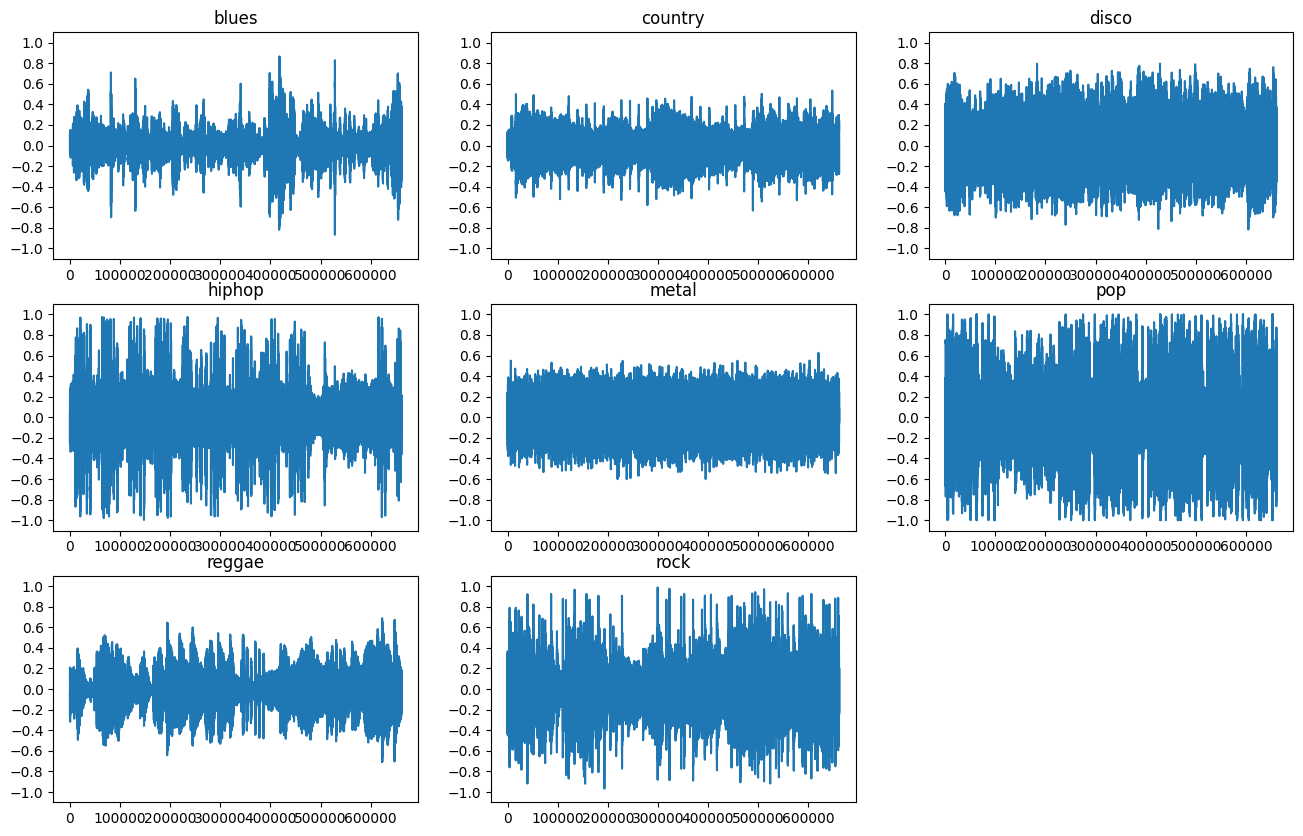

In [10]:
# Definieer label_names
label_names = {"blues": 0, "country": 1, "disco": 2, "hiphop": 3, "metal": 4, "pop": 5, "reggae": 6, "rock": 7}

# Definieer voorbeelden van elk genre voor EDA
example_audio = []
example_labels = []

for genre, audio_data in genre_audio_data.items():
    # Kies één willekeurig voorbeeld per genre
    random_index = np.random.randint(len(audio_data))
    example_clip = audio_data[random_index]
    
    # Voeg het voorbeeld toe aan de lijst met voorbeeldaudio en de bijbehorende label aan de lijst met voorbeeldlabels
    example_audio.append(example_clip)
    example_labels.append(label_names[genre])

# Zet de lijsten om naar numpy arrays
example_audio = np.array(example_audio)
example_labels = np.array(example_labels)

# EDA-code uitvoeren
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = min(rows * cols, len(example_audio))  # Zorg ervoor dat n niet groter is dan het aantal beschikbare voorbeelden
for i in range(n):
    plt.subplot(rows, cols, i+1)
    audio_signal = example_audio[i]
    plt.plot(audio_signal)
    plt.title(list(label_names.keys())[list(label_names.values()).index(example_labels[i])])
    plt.yticks(np.arange(-1.2, 1.2, 0.2))
    plt.ylim([-1.1, 1.1])

plt.show()



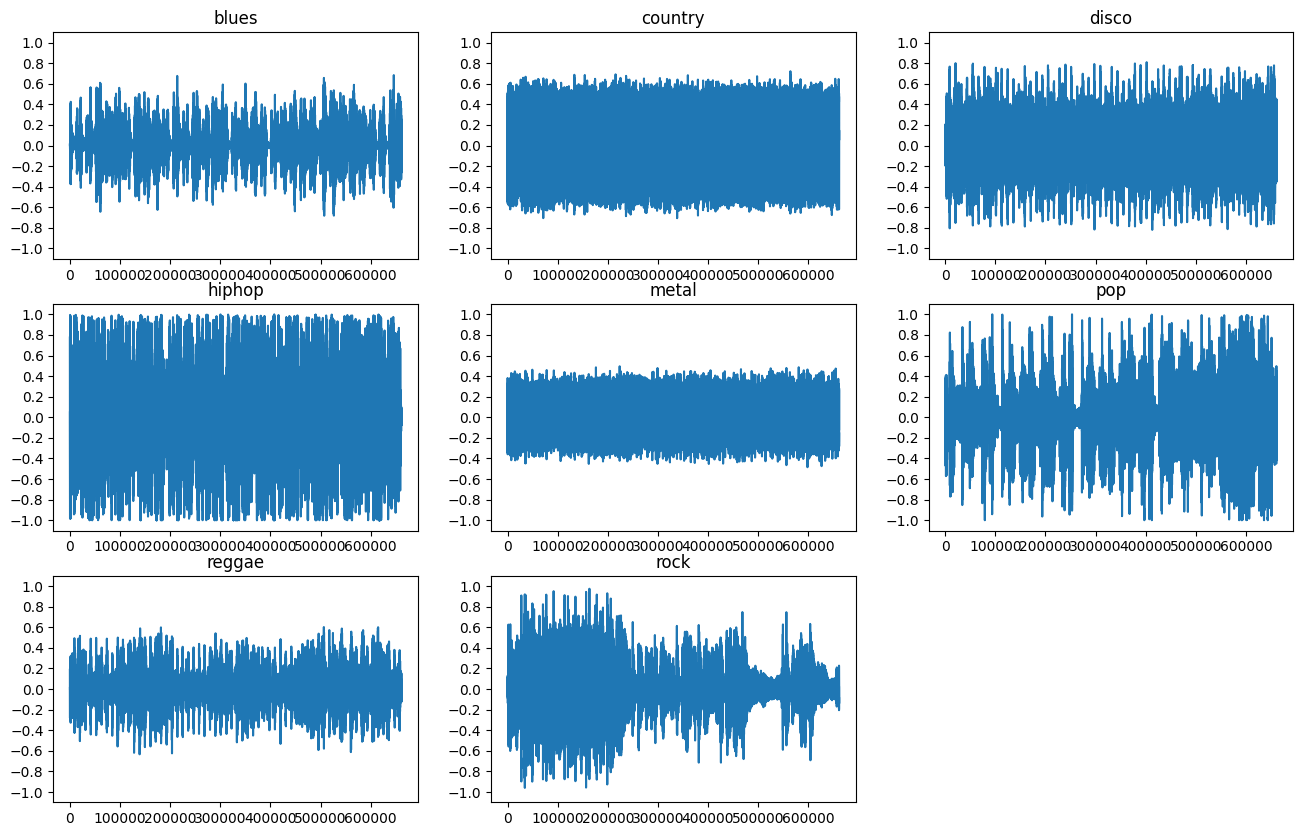

In [11]:
# Definieer label_names
label_names = {"blues": 0, "country": 1, "disco": 2, "hiphop": 3, "metal": 4, "pop": 5, "reggae": 6, "rock": 7}

# Definieer voorbeelden van elk genre voor EDA
example_audio = []
example_labels = []

for genre, audio_data in genre_audio_data.items():
    # Selecteer de eerste audio van elk genre
    example_clip = audio_data[0]
    
    # Voeg het voorbeeld toe aan de lijst met voorbeeldaudio en de bijbehorende label aan de lijst met voorbeeldlabels
    example_audio.append(example_clip)
    example_labels.append(label_names[genre])

# Zet de lijsten om naar numpy arrays
example_audio = np.array(example_audio)
example_labels = np.array(example_labels)

# EDA-code uitvoeren
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = min(rows * cols, len(example_audio))  # Zorg ervoor dat n niet groter is dan het aantal beschikbare voorbeelden
for i in range(n):
    plt.subplot(rows, cols, i+1)
    audio_signal = example_audio[i]
    plt.plot(audio_signal)
    plt.title(list(label_names.keys())[list(label_names.values()).index(example_labels[i])])
    plt.yticks(np.arange(-1.2, 1.2, 0.2))
    plt.ylim([-1.1, 1.1])

plt.show()

**Blues**

Hierboven worden de audiogolven van elk muziekgenre weergegeven, te beginnen met blues. Bluesmuziek staat bekend om zijn kalmte en rustig tempo, en dat is duidelijk te zien in de golven. Er zijn veel pieken en dalen, en de golfbewegingen blijven meestal binnen het bereik van -0.6 tot 0.6. Wanneer de golven boven de nul uitkomen, betekent dit dat het geluid een hogere amplitude heeft en dus luider is. Aan de andere kant, wanneer de golven onder nul gaan, betekent dit dat het geluid zachter is. Deze rustige en gestage golfpatronen weerspiegelen het typische gevoel van bluesmuziek.

**Country**

In de audiogolven van countrymuziek zien we minder variatie in amplitude over tijd in vergelijking met bluesmuziek. De golfpatronen blijven doorgaans tussen 0.6 en -0.6, wat betekent dat de amplitude binnen een beperkt bereik blijft. Een opvallend verschil tussen blues en country is de mate van variatie. Waar bij blues meer pieken en dalen te zien zijn, vertonen de golven van countrymuziek een constanter patroon. 

**Disco**

In de audiogolven van disco zien we een constant patroon, meestal binnen het bereik van -0.4 tot 0.4. Maar, in tegenstelling tot countrymuziek, stijgen de pieken en dalen van de disco-golven verder boven dit constante patroon uit, vaak tot 0.8 en -0.8. Deze pieken en dalen die verder reiken dan het constante patroon kunnen wijzen op een energieker geluid. De hogere pieken suggereren luide passages in de muziek, terwijl de diepere dalen rustigere momenten kunnen vertegenwoordigen. Over het algemeen geeft dit patroon een gevoel van dynamiek en ritme aan de disco-muziek. 

**HipHop**

Deze visualisatie van HipHop toont eerst een constant bereik tussen 0.6 en -0.6, vergelijkbaar met countrymuziek. Daarna worden de pieken en dalen veel sterker en gaan ze zelfs voorbij de 1 en onder de -1. Dit betekent dat hiphopmuziek vaak rustige stukken heeft, gevolgd door luide en dynamische delen. De diepe dalen zijn de rustigere momenten, terwijl de hoge pieken de luide en energieke delen van de muziek laten zien. Dit patroon draagt bij aan het ritmische en levendige karakter van hiphopmuziek.

**Metal**

Nu, laten we naar metal kijken. In deze visualisatie zien we een constant bereik tussen 0.4 en -0.4. Dit betekent dat metalmuziek over het algemeen luider is dan bijvoorbeeld blues of country, maar niet zo dynamisch als bijvoorbeeld hiphop. De constante golfvorm suggereert een voortdurende en intense geluidssterkte, wat kenmerkend is voor het genre. De relatief beperkte variatie in amplitude suggereert een consistent en krachtig geluid dat typerend is voor metal.

**Pop**

Laten we eens kijken naar popmuziek. In tegenstelling tot de eerdere genres, zien we hier geen constant patroon. De golfvormen variëren tussen 0.1 en -0.1, maar we zien ook pieken en dalen tot 1 en -1. Dit kan duiden op een gevarieerd geluid met zowel zachte als luide passages. Popmuziek staat erom bekend dynamisch en levendig te zijn, met wisselende volumes en intensiteit. Deze variatie in amplitude kan verschillende elementen van popmuziek weerspiegelen, zoals de opbouw van het nummer, het gebruik van instrumenten en de vocale stijl.

**Reggae**

Laten we eens kijken naar reggaemuziek. Hier zien we een constant patroon met golfvormen tussen 0.2 en -0.2. Dit constante niveau wordt gevolgd door pieken en dalen die variëren tussen 0.6 en -0.6. Dit kan worden geassocieerd met de karakteristieke ritmes van reggaemuziek. Het constante patroon kan de steady groove weerspiegelen die vaak te vinden is in reggaenummers. De daaropvolgende pieken en dalen kunnen wijzen op accenten of syncopatie die kenmerkend zijn voor reggaeritmes, waardoor de muziek een swingend en dansbaar gevoel krijgt.

**Rock**

Bij rockmuziek zien wij ten eerst een constant patroon tussen 0.6 en -0.6, waarbij ook pieken en dalen boven op het constante patroon verschijnen, variërend van 1 tot -1. Na ongeveer 1/3 van het nummer verandert het patroon volledig. Het constante patroon verdwijnt en er zijn alleen nog maar pieken en dalen zichtbaar, variërend tussen 0.6 en -0.6. Dit kan de overgang naar een luider en intenser deel van het nummer markeren, wat typerend is voor veel rocknummers.

<div style="background-color:#006069; color:white; padding: 10px;">
    <strong>Spectrogram</strong>
</div>


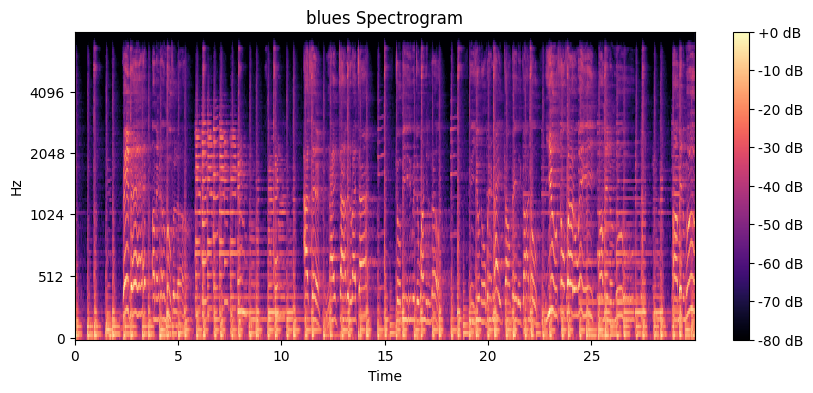

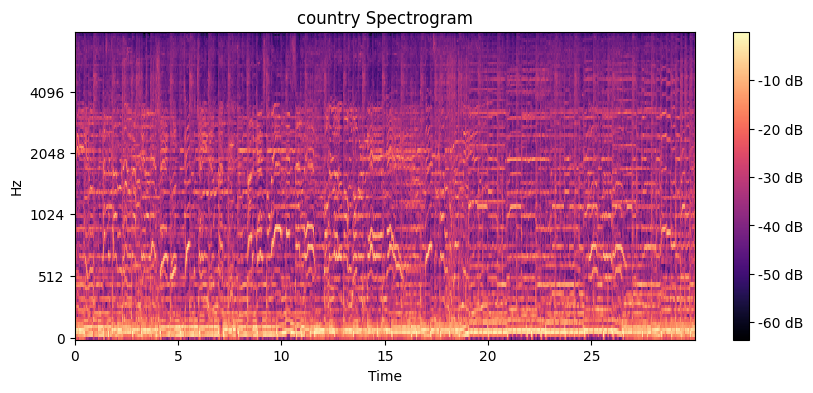

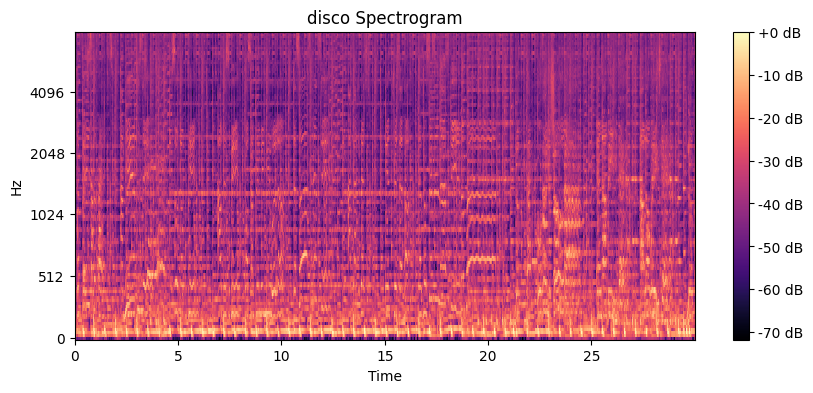

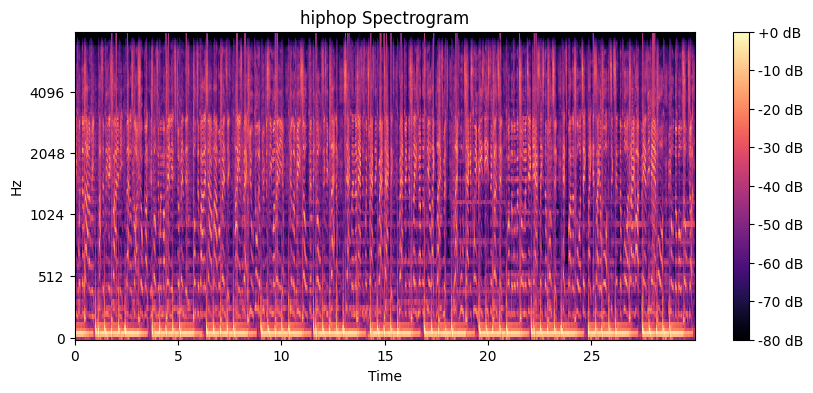

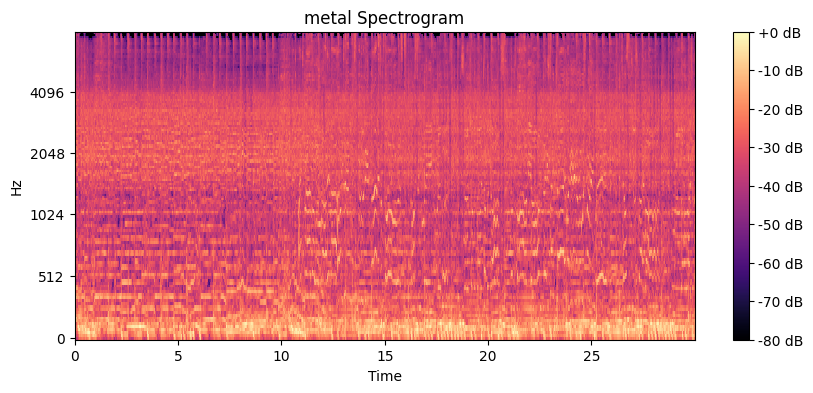

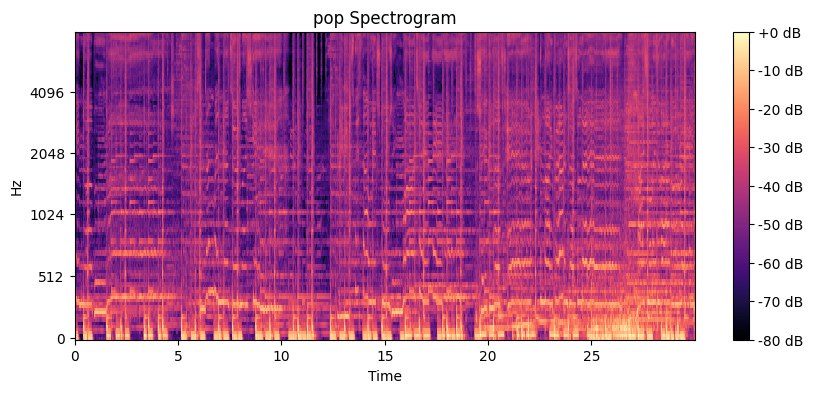

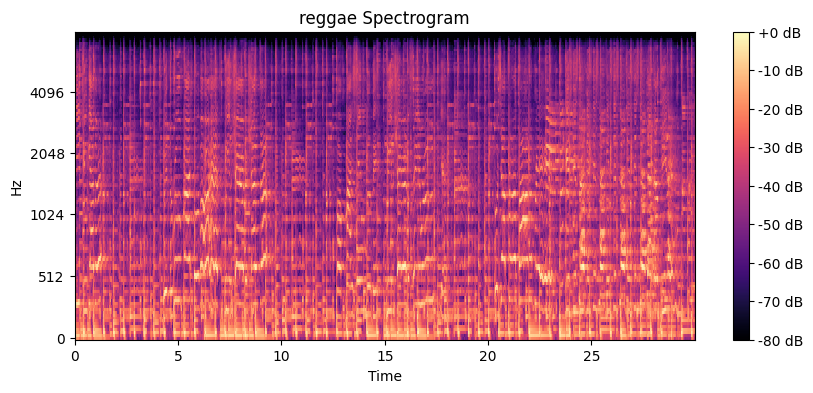

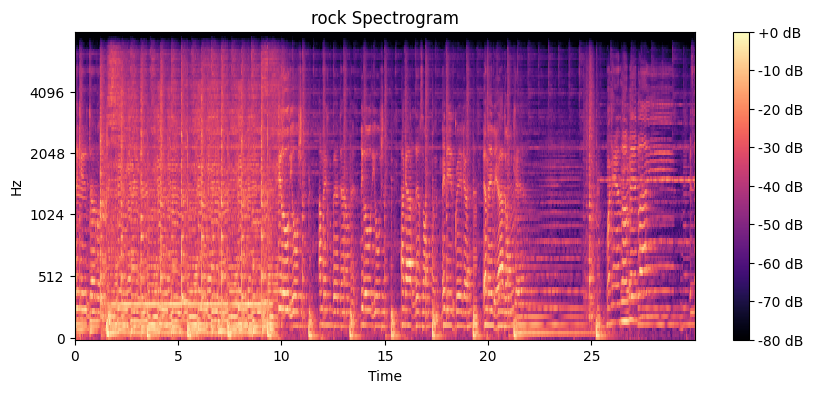

In [12]:
import matplotlib.pyplot as plt
import librosa.display

def plot_spectrogram(audio_data, sample_rate, genre):
    plt.figure(figsize=(10, 4))
    spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate)
    librosa.display.specshow(librosa.power_to_db(spectrogram, ref=np.max), y_axis='mel', fmax=8000, x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'{genre} Spectrogram')
    plt.show()

# Voorbeeldaudiobestand per genre
genres = ["blues", "country", "disco", "hiphop", "metal", "pop", "reggae", "rock"]

for genre in genres:
    audio_data = genre_audio_data[genre][0]  # Neem het eerste audiobestand van elk genre als voorbeeld
    sample_rate = genre_sample_freqs[genre][0]  # Neem de bemonsteringsfrequentie van het voorbeeldbestand
    plot_spectrogram(audio_data, sample_rate, genre)


De spectrogrammen bieden een diepgaande kijk op de frequentie- en tijdskenmerken van verschillende muziekgenres. Laten we eens kijken naar hoe de spectrogrammen van verschillende genres eruit zien en wat ze ons vertellen:

**Blues**

Het spectrogram van bluesmuziek toont een geleidelijke afname van geluidssterkte naarmate de frequentie toeneemt. Dit betekent dat het geluid voornamelijk geconcentreerd is in lagere frequentiebereiken, wat typerend is voor bluesmuziek. De lagere geluidssterkte in hogere frequentiegebieden draagt bij aan de kalmte en zachtheid van het genre.

**Country**

Vergelijkbaar met blues, toont het spectrogram van countrymuziek ook een afname van geluidssterkte bij hogere frequenties, maar deze afname is minder steil. Dit suggereert dat countrymuziek helderder en levendiger klinkt dan bluesmuziek, met meer nadruk op hogere frequentiegebieden.

**Disco**

Het spectrogram van disco vertoont een gelijkenis met countrymuziek, maar met minder aanwezigheid van geluiden in het middelste frequentiebereik. Dit kan wijzen op een nadruk in disco op lage en hoge frequenties, terwijl middelhoge frequenties minder prominent aanwezig zijn.

**HipHop**

De lage frequenties in het spectrogram van hiphopmuziek vertonen een gematigd geluidsniveau, wat kan worden geassocieerd met baslijnen. De pieken in het middenfrequentiebereik kunnen corresponderen met drums of beats, terwijl de hogere frequenties waarschijnlijk gerelateerd zijn aan vocalen of melodische elementen.

**Metal**

Het brede frequentiebereik in het spectrogram van metalmuziek, met een gematigd geluidsniveau over het hele spectrum, weerspiegelt de complexiteit en dichtheid van de instrumentatie in metalnummers. Dit geeft de volle en rijke geluidsproductie weer die kenmerkend is voor dit genre.

**Pop**

Het spectrogram van popmuziek laat een typisch patroon zien, met een gematigd geluidsniveau in lagere frequenties, zoals basgeluiden en drums, en een lager geluidsniveau in hogere frequenties, zoals zang en melodieën. Dit weerspiegelt de productiestijl van popmuziek, waarbij ritmische elementen prominenter aanwezig zijn dan melodische elementen.

**Reggae**

Het spectrogram van reggaemuziek vertoont overeenkomsten met popmuziek, maar met een verhoogde geluidssterkte in het middenfrequentiebereik. Dit kan wijzen op een verhoogde aanwezigheid van ritmische en melodische elementen, wat kenmerkend is voor reggaemuziek.

**Rock**

Het spectrogram van rockmuziek vertoont een overgang van een gelijkmatig geluidsniveau over het gehele frequentiebereik naar lagere geluidsniveaus in bepaalde frequentiegebieden. Deze verandering kan duiden op een overgang naar meer gevarieerde instrumentatie en harmonische structuren binnen het genre.

In alle spectrogrammen kunnen we de unieke geluidssignaturen van elk genre zien, wat ons een dieper inzicht geeft in hun muzikale kenmerken en productiestijlen.

<div style="background-color:#006069; color:white; padding: 10px;">
    <strong>MFCC</strong>
</div>

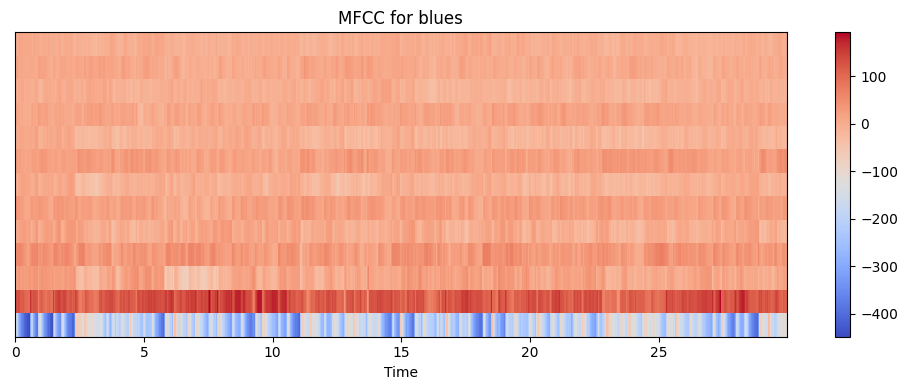

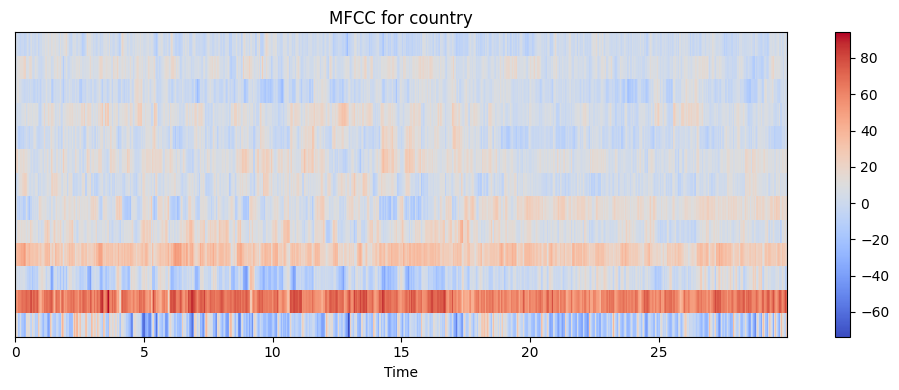

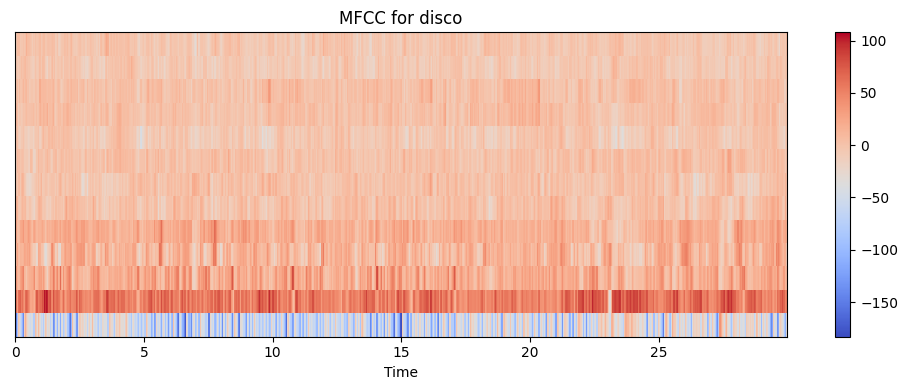

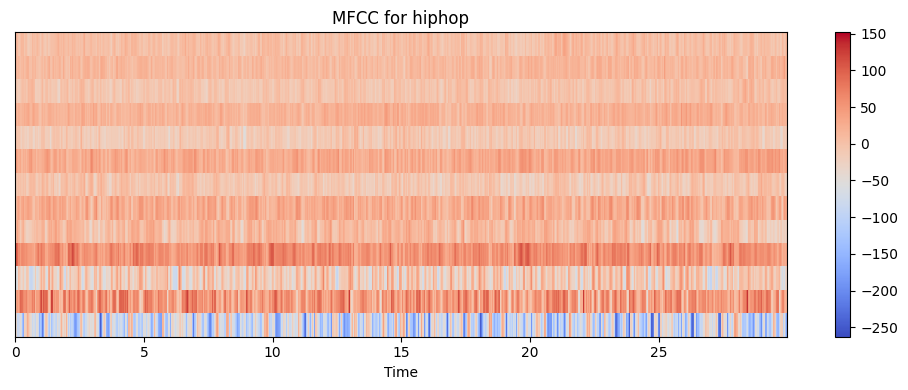

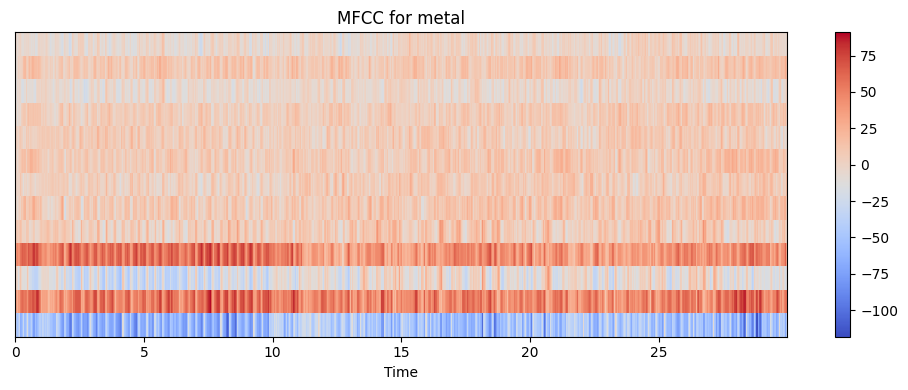

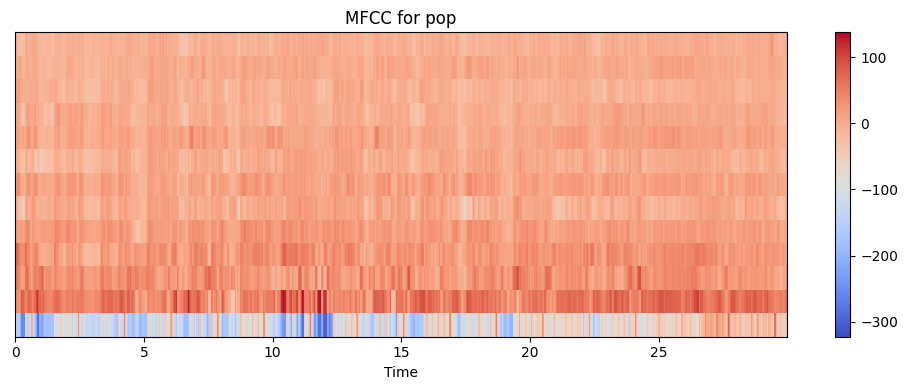

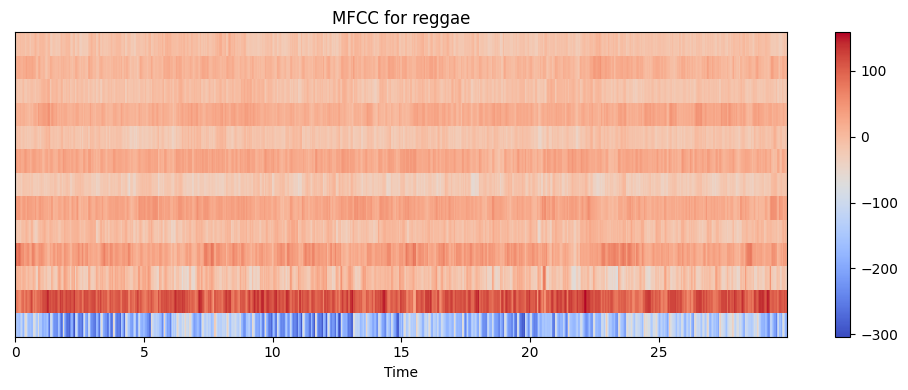

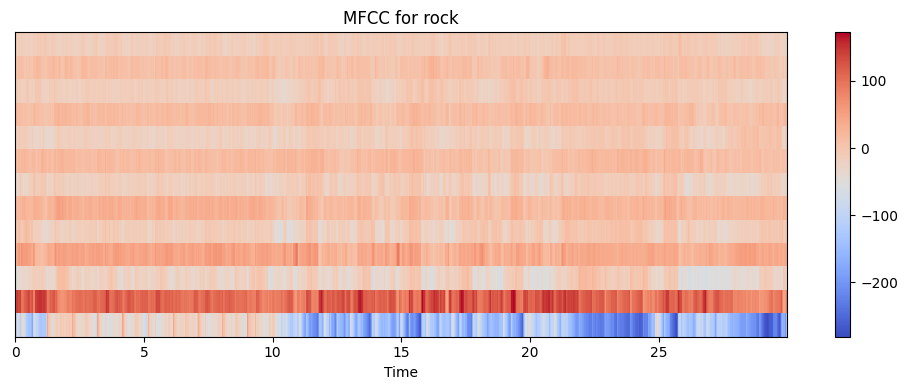

In [13]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Functie om MFCC's te berekenen en te plotten voor een specifiek genre
def plot_mfcc_for_genre(genre_audio_data, genre_sample_freqs, genre_name):
    example_audio_data = genre_audio_data[genre_name][0]  # Neem een voorbeeld audiobestand
    example_sample_rate = genre_sample_freqs[genre_name][0]  # Neem de sample rate van het voorbeeld audiobestand
    plot_mfcc(example_audio_data, example_sample_rate, genre_name)

# Functie om MFCC's te berekenen en te plotten
def plot_mfcc(audio_data, sample_rate, genre_name):
    # Bereken MFCC's
    mfccs = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=13)

    # Plot MFCC's
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mfccs, x_axis='time')
    plt.colorbar()
    plt.title(f'MFCC for {genre_name}')
    plt.tight_layout()
    plt.show()

# Loop over elk genre en genereer MFCC-plots
for genre_name in genre_audio_data.keys():
    plot_mfcc_for_genre(genre_audio_data, genre_sample_freqs, genre_name)


In de visualisaties van de MFCC's (Mel-Frequency Cepstral Coefficients) zien we interessante patronen die kenmerkend zijn voor verschillende muziekgenres.

**Blues**

De bluesvisualisatie toont een nadruk op lagere frequenties, die worden vertegenwoordigd door de blauwe balkjes. Dit past goed bij het genre, waarin de basgitaar een prominente rol speelt. Hogere frequenties, mogelijk afkomstig van instrumenten zoals elektrische gitaren, worden weergegeven door de donkerrode balkjes. De concentratie van balkjes rond de 0 suggereert de aanwezigheid van vocale frequenties, wat typerend is voor de vocale expressie in bluesmuziek.

**Country**

Voor countrymuziek zien we een vergelijkbare trend, maar met een iets andere verdeling. De lagere balkjes vertegenwoordigen nog steeds basgeluiden, maar we zien ook donkerdere rode balkjes die hogere frequenties weergeven, zoals die van melodieën van bijvoorbeeld violen of banjo's. Stemfrequenties, essentieel voor de harmonieën in countrymuziek, worden weergegeven door de lichtblauwe balkjes.

**Disco**

Discomuziek vertoont een opvallende nadruk op ritme en percussie, zoals te zien is aan de donkere blauwe balkjes die lagere frequenties vertegenwoordigen. De lichtere blauwe balkjes vertegenwoordigen hogere frequenties, zoals die van melodieën en instrumenten zoals synthesizers en gitaren. Stemgeluiden zijn ook aanwezig, aangezien zang een belangrijk element is in discosongs.

**HipHop**

Bij hip-hop zien we diepe basgeluiden en ritmesecties weergegeven door lagere balkjes, terwijl hogere frequenties, zoals die van drumbeats en melodieën, worden vertegenwoordigd door rode balkjes. De variatie in frequenties weerspiegelt de complexe en ritmische aard van hip-hopmuziek.

**Metal**

Metal visualiseert een krachtig geluid met diepe basgeluiden, agressieve drums en intense gitaarmelodieën. De verschillende kleuren en hoogtes van de balkjes vertegenwoordigen de diversiteit aan instrumenten en geluiden die typisch zijn voor dit genre.

**Pop**

Popmuziek laat een evenwichtige mix zien van lagere en hogere frequenties, wat overeenkomt met de diverse geluiden en stijlen die vaak in popliedjes te horen zijn. Baslijnen en percussie worden vertegenwoordigd door lagere balkjes, terwijl hogere balkjes melodieën en vocale harmonieën aanduiden.

**Reggae**

Reggaemuziek toont diepe basgeluiden en percussieritmes, aangevuld met hogere frequenties van instrumenten zoals gitaren en keyboards. Stemgeluiden zijn prominent aanwezig, wat de nadruk op zang en harmonie in reggaemuziek weerspiegelt.

**Rock**

Tenslotte, rockmuziek wordt gekenmerkt door zware baslijnen, scherpe gitaarpartijen en energieke percussie. Deze elementen worden weerspiegeld in de frequentiepatronen van de visualisatie, waarbij lagere balkjes de bas- en ritmesecties vertegenwoordigen, terwijl hogere balkjes de gitaarpartijen en vocale harmonieën aanduiden.

<div style="background-color:#006069; color:white; padding: 10px;">
    <strong>Fast Fourier Transform</strong>
</div>


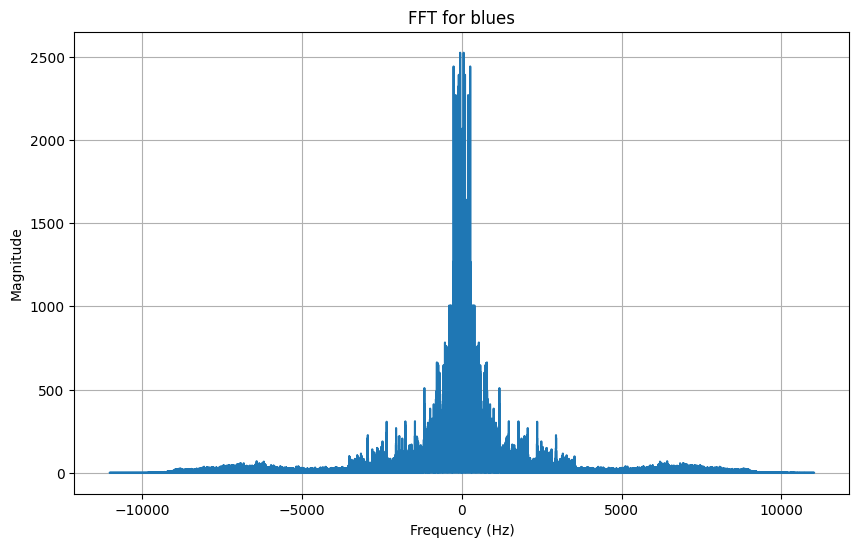

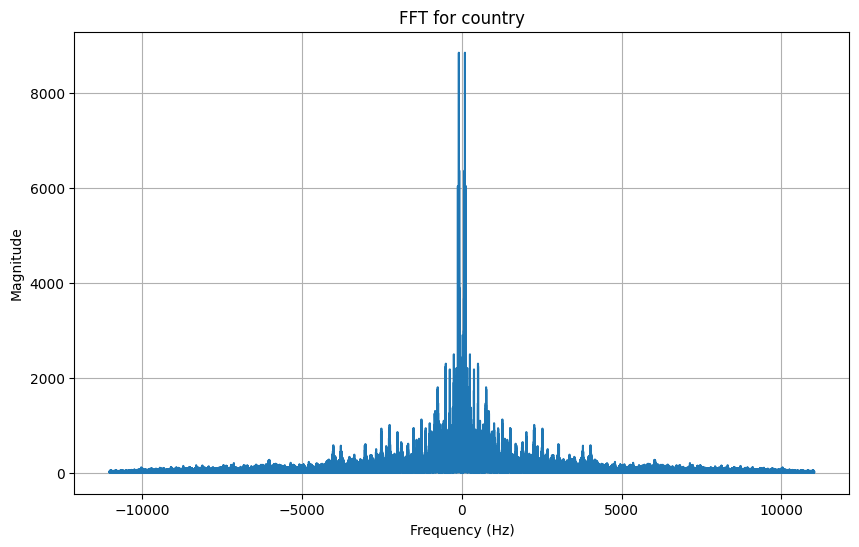

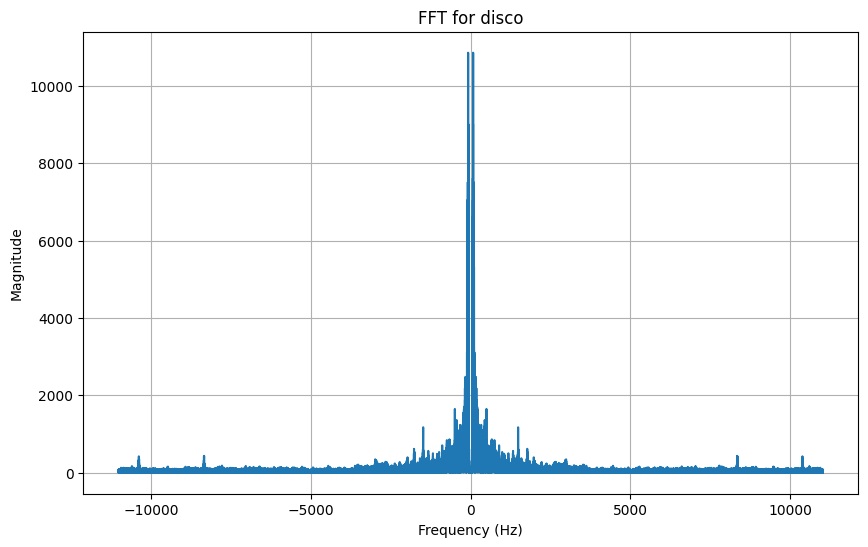

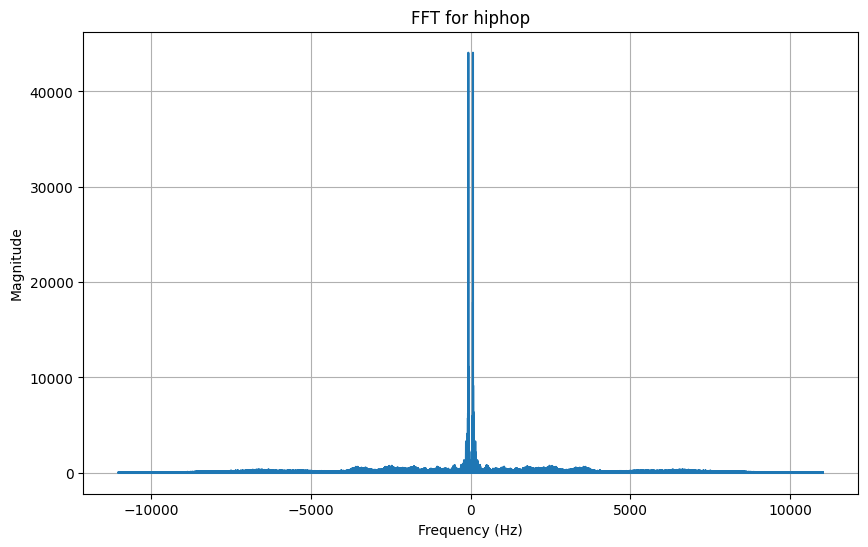

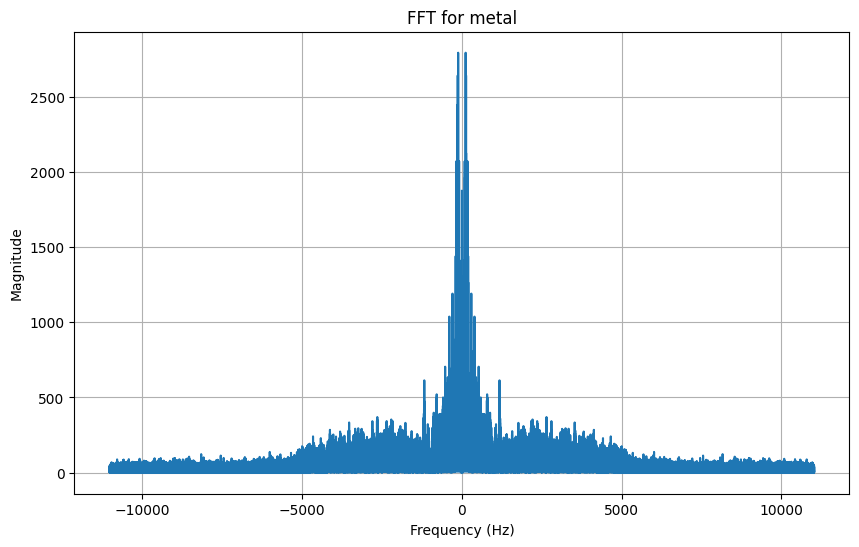

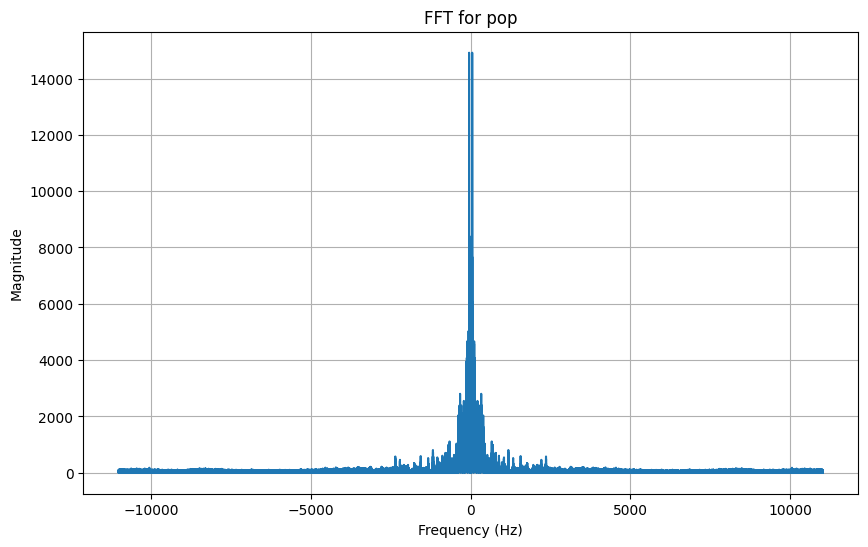

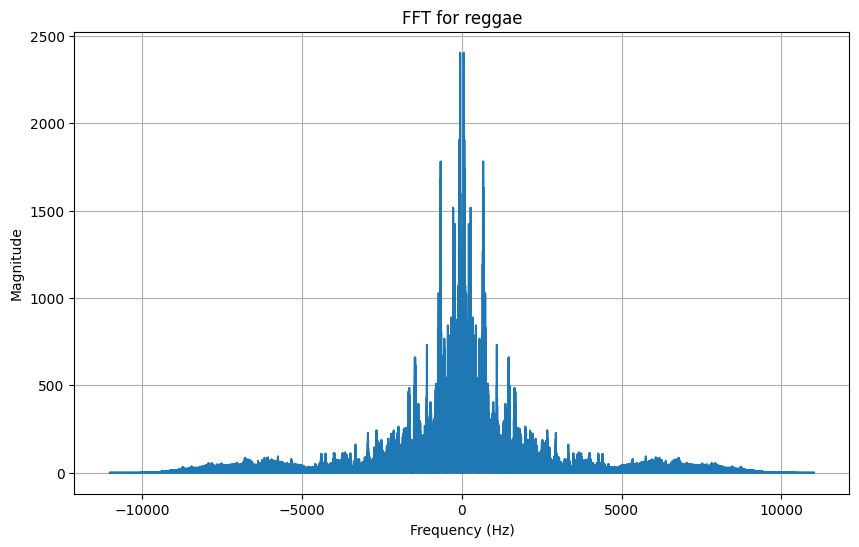

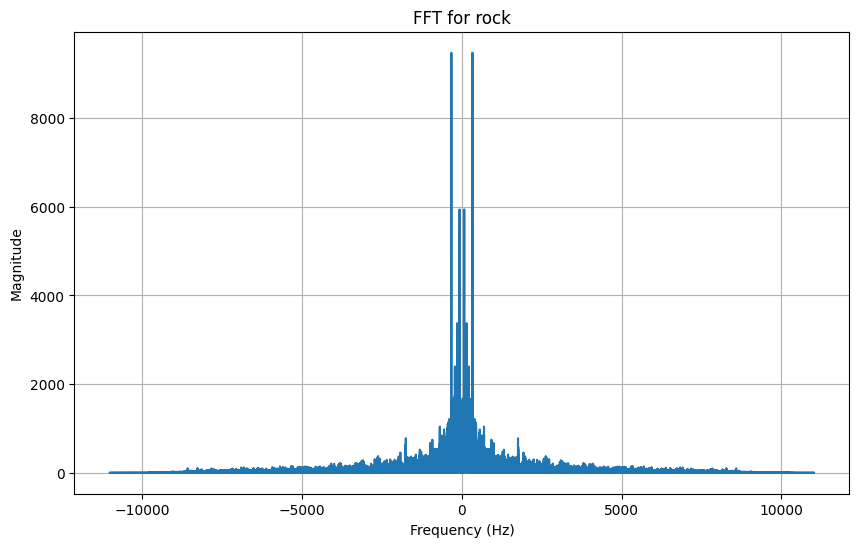

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Function to compute FFT for audio data
def compute_fft(audio_data, sample_rate):
    # Compute FFT
    fft_output = np.fft.fft(audio_data)
    
    # Compute frequencies associated with FFT
    frequencies = np.fft.fftfreq(len(fft_output), 1 / sample_rate)
    
    return frequencies, fft_output

# Loop over each genre and compute FFT
for genre_name, audio_data in genre_audio_data.items():
    # Take the first audio sample from each genre
    example_audio_data = audio_data[0]
    example_sample_rate = genre_sample_freqs[genre_name][0]
    
    # Compute FFT
    frequencies, fft_output = compute_fft(example_audio_data, example_sample_rate)
    
    # Plot FFT
    plt.figure(figsize=(10, 6))
    plt.plot(frequencies, np.abs(fft_output))
    plt.title(f"FFT for {genre_name}")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude")
    plt.grid(True)
    plt.show()


<a name='2.0'></a>

<div style="background-color:#006096; text-align:center; vertical-align:middle; padding:10px 0; margin-top:5px; margin-bottom:5px">
        <h2 style="color:white"><strong>H2: LSTM voor audioclips</strong></h2>
</div>

BRON: Stukken uit de les van week 7 (LSTM_voor_timeseries_data_–_classificatie_van_audioclips, 2024)

<div style="background-color:#006069; color:white; padding: 10px;">
    <strong>Beschrijving</strong>
</div>


We laden de data in een andere manier in dan we hiervoor hebben gedaan in het bestand. We verdelen de data niet op de traditionele train_test_split methode. Maar verdelen het in train en validation data. Deze data word gerunt in een redelijk kleine batchsize zodat het minder lang duurt bij het runnen van het model

In [15]:
data_dir = pathlib.Path("Train")

train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=8,
    validation_split=0.2,
    seed=0,
    output_sequence_length=30*22050,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 537 files belonging to 8 classes.
Using 430 files for training.
Using 107 files for validation.

label names: ['blues' 'country' 'disco' 'hiphop' 'metal' 'pop' 'reggae' 'rock']


In [16]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [17]:
train_ds.element_spec

(TensorSpec(shape=(None, 661500, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

<div style="background-color:#006069; color:white; padding: 10px;">
    <strong>Beschrijving</strong>
</div>


We halen de data terug naar een kleinere dimensie met de methode squeeze.

In [18]:
def squeeze(audio, labels=None):
    audio = tf.squeeze(audio, axis=-1)
    if labels is not None:
        return audio, labels
    else:
        return audio


In [19]:
train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [20]:
for audio, label in train_ds.take(1):
    print("Shape van audio:", audio.shape)
    print("Shape van label:", label.shape)


Shape van audio: (8, 661500)
Shape van label: (8,)


In [21]:
train_ds = train_ds.cache().shuffle(10).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(tf.data.AUTOTUNE)

<a name='2.0'></a>

<div style="background-color:#006096; text-align:center; vertical-align:middle; padding:10px 0; margin-top:5px; margin-bottom:5px">
        <h2 style="color:white"><strong>H2: Feature Engineering</strong></h2>
</div>


<div style="background-color:#006069; color:white; padding: 10px;">
    <strong>Maken van de spectrogram</strong>
</div>


In [22]:
def get_spectrogram(waveform):
    # Convert the waveform to a spectrogram via a STFT.
    spectrogram = tf.signal.stft(waveform, frame_length=512, frame_step=256)

    # Obtain the magnitude of the STFT (use tf.abs).
    spectrogram = tf.abs(spectrogram)

    # Add a `channels` dimension, so that the spectrogram can be used
    # as image-like input data with convolution layers (which expect
    # shape (`batch_size`, `height`, `width`, `channels`).
    spectrogram = spectrogram[..., tf.newaxis]

    return spectrogram

In [23]:
def make_spec_ds(ds):
    def map_func(audio, *args):
        """
        Map function to convert audio samples to spectrograms.

        Parameters:
        -----------
        audio: Audio waveform.
        *args: Additional arguments, if any.

        Returns:
        --------
        tuple or Tensor: If additional arguments are provided, returns a tuple containing
            the spectrogram and the first additional argument. Otherwise, returns just the spectrogram.
        """
        spectrogram = get_spectrogram(audio)
        if len(args) > 0:
            return spectrogram, args[0]
        else:
            return spectrogram
    return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [24]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)

display(train_spectrogram_ds)

<_ParallelMapDataset element_spec=(TensorSpec(shape=(None, 2582, 257, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [25]:
train_spectrogram_ds =train_spectrogram_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

display(train_spectrogram_ds)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 2582, 257, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

<div style="background-color:#006069; color:white; padding: 10px;">
    <strong>Beschrijving</strong>
</div>


We maken als feature spectrogrammen van de audio golven. Dit gebruiken we om van de spectrogrammen weer de MFCCS afteleiden. De make_spec functie en codeline hierboven zorgen ervoor dat het wordt aangepast op onze data

In [26]:
for audio_batch, label_batch in train_spectrogram_ds.take(1):
    print("Shape of an audio sample:", audio_batch[0].shape)

Shape of an audio sample: (2582, 257, 1)


<div style="background-color:#006069; color:white; padding: 10px;">
    <strong>Maken van de MFFCS</strong>
</div>
bron: functie van de les

In [27]:
def spectrogram_to_mfcc(spectrograms, num_mel_bins=128, num_coefficients=20, sample_rate=16000):
    """
    Convert a batch of spectrograms to a batch of 1D time series of MFCCs.

    Parameters:
    - spectrograms: A TensorFlow Tensor representing a batch of spectrograms with shape (batch_size, 311, 257, 1).
    - num_mel_bins: Number of Mel bins to use.
    - num_coefficients: Number of MFCC coefficients to return.
    - sample_rate: Sample rate of the audio.

    Returns:
    - A TensorFlow Tensor containing the MFCCs with shape (batch_size, num_frames, num_coefficients).
    """
    # Remove the last dimension (channel dimension, if it's 1)
    spectrograms = tf.squeeze(spectrograms, axis=-1)

    # Compute Mel spectrograms
    stfts_to_mel_matrix = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins=num_mel_bins,
        num_spectrogram_bins=spectrograms.shape[-1],
        sample_rate=sample_rate,
        lower_edge_hertz=20.0,
        upper_edge_hertz=sample_rate / 2)
    mel_spectrograms = tf.tensordot(spectrograms, stfts_to_mel_matrix, 1)
    # Shape tuning for the mel spectrograms as expected
    mel_spectrograms.set_shape(spectrograms.shape[:-1] + (num_mel_bins,))

    # Logarithmic scaling
    log_mel_spectrograms = tf.math.log(mel_spectrograms + 1e-6)

    # Compute MFCCs
    mfccs = tf.signal.mfccs_from_log_mel_spectrograms(log_mel_spectrograms)[..., :num_coefficients]

    return mfccs

In [28]:
def make_MFCC_ds(ds):
    """
    Convert a spectrogram dataset into a dataset of Mel-frequency cepstral coefficients (MFCCs).

    Parameters:
    ds (tf.data.Dataset): The input spectrogram dataset.

    Returns:
    --------
    tf.data.Dataset: The dataset of MFCCs.
    """
    def map_func(spectrogram, *args):
        mfcc = spectrogram_to_mfcc(spectrogram)
        if len(args) > 0:
            return mfcc, args[0]
        else:
            return mfcc
    return ds.map(map_func, num_parallel_calls=tf.data.AUTOTUNE)

In [29]:
train_MFCC_ds = make_MFCC_ds(train_spectrogram_ds)
val_MFCC_ds = make_MFCC_ds(val_spectrogram_ds)

<div style="background-color:#006069; color:white; padding: 10px;">
    <strong>Beschrijving</strong>
</div>


Hierboven maken we van de eerder gedefineerde spectrogrammen, MFCCS per audio clip. Dit geeft nogmeer informatie over de audio clips en zorgt ervoor dat het model duidelijkere patronen kan herkennen

In [30]:
for example_MFCC, example_MFCC_labels in train_MFCC_ds.take(1):
    break

display(example_MFCC)

<tf.Tensor: shape=(8, 2582, 20), dtype=float32, numpy=
array([[[-1.82598388e+00,  1.46779323e+00,  2.62092113e+00, ...,
          1.18996096e+00,  1.82452476e+00,  1.77678180e+00],
        [-1.20481241e+00,  2.12665749e+00,  1.53485787e+00, ...,
          1.03352535e+00,  1.69712472e+00,  2.49649358e+00],
        [-4.46094275e-01,  1.18774211e+00,  1.18414176e+00, ...,
          1.55811477e+00,  1.22047973e+00,  2.25584745e+00],
        ...,
        [ 1.03758011e+01,  1.05696869e+00, -1.00090611e+00, ...,
         -4.69130278e-02,  4.40113664e-01,  2.92233586e-01],
        [ 9.49782562e+00,  1.93122590e+00, -1.00396919e+00, ...,
         -4.16375428e-01,  2.08892733e-01,  1.01237214e+00],
        [ 9.64153671e+00,  2.85174370e+00, -8.33730280e-01, ...,
          1.78013414e-01,  1.36194682e+00,  1.25443149e+00]],

       [[ 2.62129211e+00, -4.79809761e+00, -1.78283000e+00, ...,
          1.57882214e+00, -3.03074002e-01,  5.16532063e-01],
        [ 6.52681828e+00, -5.41438770e+00,  7.91

In [31]:
train_MFCC_ds = train_MFCC_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_MFCC_ds = val_MFCC_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

display(train_MFCC_ds)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 2582, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [32]:
for audio_batch, label_batch in train_MFCC_ds.take(1):
    print("Shape of an audio sample:", audio_batch[0].shape)

Shape of an audio sample: (2582, 20)


In [33]:
val_MFCC_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 2582, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

<a name='2.0'></a>

<div style="background-color:#006096; text-align:center; vertical-align:middle; padding:10px 0; margin-top:5px; margin-bottom:5px">
        <h2 style="color:white"><strong>H2: Modelleren</strong></h2>
</div>


In [41]:
input_shape = example_MFCC.shape[1:]

model= models.Sequential([
    layers.Input(shape=input_shape),
    Bidirectional(LSTM(128, return_sequences=True,)),
    Dropout(0.3),
    BatchNormalization(),
    Bidirectional(LSTM(64, return_sequences=True,)),
    Dropout(0.3),
    BatchNormalization(),
    Bidirectional(LSTM(32, return_sequences=True,)),
    Dropout(0.3),
    BatchNormalization(),
    Bidirectional(LSTM(16, return_sequences=False,)),
    Dropout(0.3),
    BatchNormalization(),
    Dense(8, activation='softmax')
])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_9 (Bidirecti  (None, 2582, 256)         152576    
 onal)                                                           
                                                                 
 dropout_9 (Dropout)         (None, 2582, 256)         0         
                                                                 
 batch_normalization_9 (Bat  (None, 2582, 256)         1024      
 chNormalization)                                                
                                                                 
 bidirectional_10 (Bidirect  (None, 2582, 128)         164352    
 ional)                                                          
                                                                 
 dropout_10 (Dropout)        (None, 2582, 128)         0         
                                                      

<div style="background-color:#006069; color:white; padding: 10px;">
    <strong>Model Architechtuur</strong>
</div>

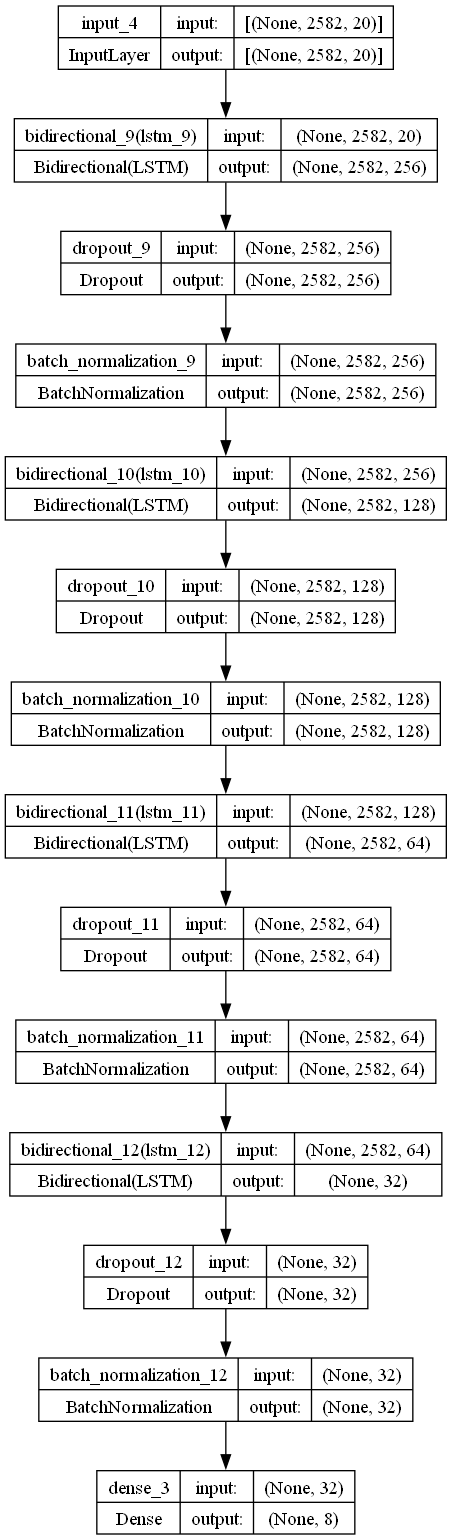

In [42]:
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

<div style="background-color:#006069; color:white; padding: 10px;">
    <strong>Model Trainen</strong>
</div>

In [43]:
stop_early = EarlyStopping(monitor='val_loss', patience=5)

In [44]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                   loss="sparse_categorical_crossentropy",
                   metrics=["accuracy"])
history = model.fit(train_MFCC_ds, epochs=25, validation_data=val_MFCC_ds, batch_size=30)

Epoch 1/100


54/54 [==============================] - 218s 4s/step - loss: 2.2306 - accuracy: 0.2163 - val_loss: 1.8864 - val_accuracy: 0.3922
Epoch 2/100
54/54 [==============================] - 206s 4s/step - loss: 1.8575 - accuracy: 0.3395 - val_loss: 1.7609 - val_accuracy: 0.3529
Epoch 3/100
54/54 [==============================] - 207s 4s/step - loss: 1.7160 - accuracy: 0.3721 - val_loss: 1.7159 - val_accuracy: 0.3529
Epoch 4/100
54/54 [==============================] - 236s 4s/step - loss: 1.6189 - accuracy: 0.4256 - val_loss: 1.7503 - val_accuracy: 0.3922
Epoch 5/100
54/54 [==============================] - 228s 4s/step - loss: 1.5149 - accuracy: 0.4488 - val_loss: 1.7925 - val_accuracy: 0.3333
Epoch 6/100
54/54 [==============================] - 226s 4s/step - loss: 1.3699 - accuracy: 0.4930 - val_loss: 1.8056 - val_accuracy: 0.3725
Epoch 7/100
54/54 [==============================] - 228s 4s/step - loss: 1.3499 - accuracy: 0.5070 - val_loss: 1.9749 - val_accuracy: 0.3137
Epoch 8/100
54/54 

<div style="background-color:#006069; color:white; padding: 10px;">
    <strong>Model Visualiseren</strong>
</div>

In [ ]:
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], 'g', label='Validation accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Accuracy')
plt.title('Accuracy vs validation accuracy')
plt.legend()
plt.show()

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], 'g', label='Validation loss')
plt.xlabel('Epoch #')
plt.ylabel('Loss(sparse categorical crossentropy)')
plt.title('Loss vs validation loss')
plt.legend()
plt.show()

<div style="background-color:#006069; color:white; padding: 10px;">
    <strong>Uitleg keuze features (Spectrogram)</strong>
</div>

https://emastered.com/nl/blog/what-is-spectrogram

Voor het modelleren is het handig om meerdere features te gebruiken zodat het model meer data heeft om mee te werken. We hebben 2 features gebruikt om op onze data te komen voor het model

Als eerste feature hebben we gekozen voor spectrogrammen. Normale audio spelen zich af in 2 dimensies. De meest gebruikelijke versie hiervan zijn audiogolven. Bij de audiogolfvorm wordt de "tijd" weergeven op de X-as en de "golfamplitude", die ook wel de luidheid van de audio genoemd wordt, gemeten langs de Y-as.

Deze data wordt getoond door middel van een grafiek voor audio of geluid en op die manier is het mogelijk om de golfvorm tot op een bepaald niveau te kunnen lezen zonder dat je naar de opname zelf hoeft te luisteren.

Wat een spectrogram onderscheidt van een normale audiogolfvorm is dat de audiografiek die je hierboven ziet een nieuwe dimensie heeft, genaamd "frequentie-inhoud van de audio". Door deze extra informatiebron kun je veel meer lezen over het audiobestand voordat je er überhaupt naar hebt geluisterd.

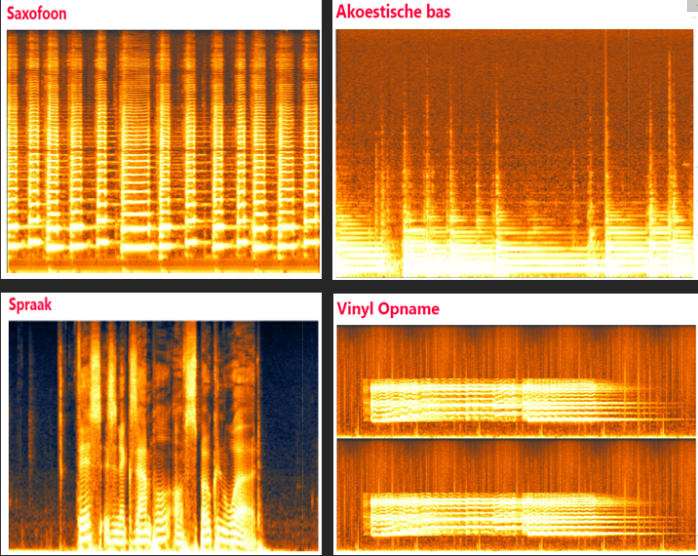

<div style="background-color:#006069; color:white; padding: 10px;">
    <strong>Uitleg keuze features (MFCCS)</strong>
</div>

MFCCS staat voor  (Mel-Frequency Cepstral Coefficients)

Mel-frequency:
De perceptie van geluidsfrequenties door het mensenlijk oor is niet uniform. Mel-Frequency scaling is een vorm van scaling die specifiek is ontworpen om de perceptie van geluid beter te weergeven dan de standaard schaal die we vaak gebruiken "Hertz (HZ)". Deze schaal is van belang bij het begrijpen hoe mensen verschillende frequenties ervaren (Music Information Retrieval (z.d.))

Cepstral Coefficients: 
Ceptrale analyse wordt gebruikt om informatie te krijgen over periodische en resonante eigenschap. Dit zijn de aanwezigheid van herhaling en regelmaat (Periodisch) en de aanwezigheid van een sterke response op trillingen of vibraties door frequenties. (Math Works. 2023.).

MFCC's bieden een zeer goede representatie van audiogegevens door de audio perceptie van mensenlijk gehoor duidelijk te kunnen weergeven. De MFFC's bieden een compacte weergave van geluid waardoor het makkelijk te verwerken is zowel als er veel als weinig gegevens voor handen zijn.




<div style="background-color:#006069; color:white; padding: 10px;">
    <strong>Uitleg aantal epochs</strong>
</div>

We hebben gekozen voor 25 epochs. Dit komt vooral door de tijd die elke epoch nodig heeft om te runnen. Wij denken dat 25 epochs al een ruim genoeg beeld geeft in de visualisaties, ookal hadden we verder kunnen experimenteren met hogere epoch aantallen.

<div style="background-color:#006069; color:white; padding: 10px;">
    <strong>Uitleg loss Function en Optimizer keuze</strong>
</div>

Bij het kiezen van de juiste loss funcion en optimizer moeten we eerst vaststellen wat de opdracht is die we moeten oplossen. Wat wij moeten doen tijdens dit portfolio is om met de gegeven data te voorspellen welke genre hoort bij een bepaald liedje. We hebben bij de trainset 8 genres en dus ook 8 mogelijke uitkomsten

Dit is waarom we "Sparse categorical cross entropy" gebruiken. 8 mogelijke uitkomsten duid aan dat het een classificatie taak is. Deze loss functie accepteerd alleen one-hot encoded labels. Dus in plaats van dat blues [0,1,0] zou zijn geeft het gewoon een integer getal aan blues 1, rock 2 etc..

We gebruiken Adam als optimizer. Dit hebben wij gekozen omdat Adam goed om kan gaan met ruis en goed is voor het handelen van grote hoeveelheden data. Adam zorgt er daarom ook voor dat het model sneller en efficienter runt. Sinds we werken met redelijk veel data 

Adam houdt tijdens het trainen twee momenten van de gradiënt bij: het gemiddelde van de gradiënten en het gemiddelde van de kwadraten van de gradiënten. Hierdoor kan Adam verschillende leersnelheden gebruiken voor elke parameter van het model, wat leidt tot efficiënter leren. Het past de stapgrootte aan op basis van deze momenten en gebruikt informatie over hoe de loss functie verandert om de fout te verkleinen. De uiteindelijke metric voor het trainen van het model is de nauwkeurigheid, waarmee wordt beoordeeld hoeveel liedjes correct zijn geclassificeerd naar genre.


<div style="background-color:#006069; color:white; padding: 10px;">
    <strong>Onderbouweing keuze parameters</strong>
</div>


Voor het trainen van het model hebben we gekozen voor een voor een even getal aan neuronen dat zich bij elke laag verminderd met de helft. Dit kiezen we omdat neurale netwerken het best werken met machten van 2. De lagen halveren zich zodat het model goed leert van de laag ervoor en de data steeds compacter moet vastleggen, dit kan ook helpen tegen overfitting. Op deze manier leert het model het beste vs eerste laag 

We hebben gekozen voor Bidirectionele-LSTM lagen. Dit zorgt ervoor dat het model niet alleen naar de laag ervoor kijkt maar ook naar de laag die erna komt (in de toekomst)

Ons model begint bij 128 neuronen en bouwt af tot 8 omdat dit de uiteindelijke output-layer moet zijn sinds wij 8 uitkomsten (genres) hebben. We hebben genoeg stappen in het model dat het model genoeg tijd heeft om patronen in de data te herkennen.

Tussen elke laag ligt een dropout laag. Wat een dropout laag doet is een gegeven % wat wordt ingevoerd (in ons geval 30%) van nodes word uitgezet en dus niet meer meedoen voor de volgende laag. Ook hebben we batchnormalization lagen. Dit houd in dat de activatie gemiddeld 0 word gehouden en de standaarddeviatie 1. Deze helpen bij het stabiliseren van het trainingsporcess door het voorkomen van vanishing gradients

In de laaste laag (de output-laag) geven we aan hoeveel uitkomsten het model moet kunnen voorspellen. In dit geval hebben wij 8 uitkomsten dus een output laag met 8 neuronen. De activatie is softmax deze gebruik je als je een model hebt met meerdere uitkomsten




<a name='2.0'></a>

<div style="background-color:#006096; text-align:center; vertical-align:middle; padding:10px 0; margin-top:5px; margin-bottom:5px">
        <h2 style="color:white"><strong>H3: LSTM voor songteksten </strong></h2>
</div>

<a name='2.0'></a>

<div style="background-color:#006096; text-align:center; vertical-align:middle; padding:10px 0; margin-top:5px; margin-bottom:5px">
        <h2 style="color:white"><strong> H4: Transformer voor songteksten </strong></h2>
</div>

https://huggingface.co/luiz826/roberta-to-music-genre

##### Voordelen van een vooraf getraind model

Wij gebruiken hieronder een pretrained model, deze hebben wij van hugging face afgehaald, genaamd "luiz826/roberta-to-music-genre". Dit is een transfer model, specifiek de RoBERTa-model. 

Bij het gebruik van een vooraf getrainde modellen bespaar je tijd. Het trainen van een model kan veel tijd en rekenkracht kosten. Het is vaak getraint op een grote dataset en soms nog meerdere datasets, dit duurt vaak heel lang om te trainen. Doordat het model op een grotere dataset is getraint zal het beter presenteren. Zo is het mogelijk om met minder data en rekenkracht alsnog goede resultaten te behalen. Deze modellen worden vaak ook up-to-date gehouden en kan je profiteren van steeds betere resultaten. Een specifiek voordeel van dit model is dat het al is getraint op engelse songteksten. Dit is zeer handig, want de songteksten die wij hebben is ook engels. 

pip install transformers, tf_keras, pipeline

De maximale hoeveelheid van tokens voor dit model is 512. Hierdoor gaan wij de de songteksten in korten tot de maximale lengte

In [ ]:
from transformers import RobertaTokenizer
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Tokenizer initialiseren
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

# Functie om songteksten in te korten tot een maximale lengte van 512 tokens
def truncate_text(text):
    # Tokenizen van de tekst
    tokens = tokenizer.encode(text, add_special_tokens=True)
    # Inhoud inkorten tot 512 tokens
    truncated_tokens = tokens[:512]
    return truncated_tokens

# Songteksten tokeniseren en inkorten
tokenized_lyrics = train['lyrics'].apply(truncate_text)

# Labelencoder initialiseren en genres labelen
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(train['genre'])

# Controleer op de lengte van de tokens
max_len = max(len(tokens) for tokens in tokenized_lyrics)
print("Maximale lengte van tokens:", max_len)

# Controleer de labels en hun corresponderende numerieke waarden
print("Unieke labels:", set(labels))
print("Labelencoder classes:", label_encoder.classes_)


In [ ]:
#code werkt maar duurt heel lang om te runnen, waarschijnlijk rond de 3 uur lang
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import RobertaTokenizer, TFAutoModelForSequenceClassification
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
import numpy as np

In [ ]:
# Tokenizer initialiseren
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

# Functie om songteksten in te korten tot een maximale lengte van 512 tokens
def truncate_text(text):
    # Tokenizen van de tekst
    tokens = tokenizer.encode(text, add_special_tokens=True)
    # Inhoud inkorten tot 512 tokens
    truncated_tokens = tokens[:512]
    return truncated_tokens

# Songteksten tokeniseren en inkorten voor train en test data
train['tokenized_lyrics'] = train['lyrics'].apply(truncate_text)
test['tokenized_lyrics'] = test['lyrics'].apply(truncate_text)


In [ ]:

# Labelencoder initialiseren en genres labelen
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train['genre'])

# Model initialiseren
model = TFAutoModelForSequenceClassification.from_pretrained("luiz826/roberta-to-music-genre")

# Train-test split
train_texts, val_texts, train_labels, val_labels = train_test_split(train['tokenized_lyrics'].tolist(), train_labels, test_size=0.1, random_state=42)


In [ ]:

# Padding en conversie naar numpy arrays
def convert_to_dataset(tokenized_texts, labels):
    input_ids = []
    attention_masks = []

    for text in tokenized_texts:
        input_ids.append(text + [0] * (512 - len(text)))
        attention_masks.append([1] * len(text) + [0] * (512 - len(text)))

    return np.array(input_ids), np.array(attention_masks), np.array(labels)

In [ ]:
train_input_ids, train_attention_masks, train_labels = convert_to_dataset(train_texts, train_labels)
val_input_ids, val_attention_masks, val_labels = convert_to_dataset(val_texts, val_labels)
test_input_ids, test_attention_masks, _ = convert_to_dataset(test['tokenized_lyrics'].tolist(), np.zeros(len(test)))

# Functie voor het opzetten van de TF datasets
def create_tf_dataset(input_ids, attention_masks, labels, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices(({"input_ids": input_ids, "attention_mask": attention_masks}, labels))
    return dataset.batch(batch_size)

batch_size = 8
train_dataset = create_tf_dataset(train_input_ids, train_attention_masks, train_labels, batch_size)
val_dataset = create_tf_dataset(val_input_ids, val_attention_masks, val_labels, batch_size)
test_dataset = create_tf_dataset(test_input_ids, test_attention_masks, np.zeros(len(test)), batch_size)  # Labels zijn niet nodig voor test dataset


##### Keuze hyperparameters

Een batchgrootte van 8 is gekozen om geheugen te besparen en trainingstijd te optimaliseren. Bij het trainen van een neuraal netwerk is de batchgrootte het aantal voorbeelden dat in één keer wordt doorgegeven aan het netwerk. Een kleinere batchgrootte zoals 8 zorgt voor minder geheugengebruik en vereist minder berekeningen per stap tijdens het trainen. Dit kan vooral gunstig zijn bij beperkte hardwarebronnen, zoals GPU-geheugen. 

De train-test split is uitgevoerd met een verhouding van 90% training en 10% validatie om overfitting te voorkomen. Een trainingsset van 90% zorgt ervoor dat het model voldoende voorbeelden heeft om te leren, terwijl de validatieset van 10% wordt gebruikt om de prestaties van het model te evalueren tijdens het trainingsproces. 

Een verhouding van 90% trainingsdata en 10% validatiedata is een goede keuze om overfitting te voorkomen. Als er te weinig voorbeelden in de validatieset zitten, kan het moeilijk zijn om de algemene prestaties van het model te beoordelen. Aan de andere kant, als de validatieset te groot is, kan er te weinig trainingsdata overblijven, wat kan leiden tot een slechter presterend model. Daarom is een verhouding van 90-10% een goede balans tussen trainingsnauwkeurigheid en modelprestaties op nieuwe, niet-geziene data.

##### Fine-tuning toelichten

Allereerst worden de songteksten voorbereid en getokeniseerd met behulp van de RoBERTa-tokenizer. De tekst wordt ingekort tot een maximale lengte van 512 tokens om te voldoen aan de inputvereisten van het model. De muziekgenres worden gelabeld met behulp van een labelencoder, waarbij elk genre wordt omgezet in een numerieke waarde die het model kan begrijpen. Het pretrained RoBERTa-model wordt geladen. Dit model heeft al veel geleerd van enorme hoeveelheden tekst uit verschillende bronnen. De dataset wordt opgesplitst in een trainingsset en een validatieset, met respectievelijk 90% en 10% van de data. Dit wordt gedaan om te voorkomen dat het model overfit aan de trainingsdata. De tokenized teksten worden gepadd en omgezet naar numpy-arrays, zodat ze als input kunnen worden gebruikt voor het model. Dit omvat het toevoegen van maskers om aan te geven welke delen van de input relevant zijn. De data wordt omgezet naar TensorFlow-datasets die geschikt zijn voor training. Tijdens het fine-tunen past het model zijn gewichten aan om zich aan te passen aan de specifieke taak van muziekgenreclassificatie. Dit gebeurt door de modelparameters aan te passen aan de hand van de trainingsdata, waarbij de voorspelde output wordt vergeleken met de werkelijke labels. Na elke epoch wordt het model geëvalueerd op de validatieset om de prestaties te controleren en overfitting te voorkomen. 

Door het fine-tunen op de specifieke taak van muziekgenreclassificatie kan het pretrained RoBERTa-model zich aanpassen aan de specifieke kenmerken van deze taak, waardoor het betere resultaten kan behalen dan wanneer het model niet gefinetuned zou zijn.

##### Keuze aantal epochs

De keuze voor het aantal epochs, in dit geval 3, is een belangrijk aspect van het fine-tuningproces van een neuraal netwerk. Het aantal epochs bepaalt hoe vaak het model door de volledige trainingsdata wordt getraind.

...

In [ ]:
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

<a name='2.0'></a>

<div style="background-color:#006096; text-align:center; vertical-align:middle; padding:10px 0; margin-top:5px; margin-bottom:5px">
        <h2 style="color:white"><strong> H5: Model naar Keuze </strong></h2>
</div>

In [ ]:
# Train data
train_audio_data = np.concatenate(list(genre_audio_data.values()))
train_labels = train['genre']

# Encoding labels
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)

# Test data
test_audio_data = np.array(test_audio_data)

# Function to calculate FFT
def calculate_fft(data):
    return np.abs(fft(data))

# Calculate FFT for train and test data
train_audio_data_fft = np.apply_along_axis(calculate_fft, 1, train_audio_data)
test_audio_data_fft = np.apply_along_axis(calculate_fft, 1, test_audio_data)

# Function to create audio model
def create_audio_model():
    model = Sequential([
        Dense(256, activation='relu', input_shape=(train_audio_data_fft.shape[1],)),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(len(label_encoder.classes_), activation='softmax')
    ])
    return model

# Create audio model
audio_model = create_audio_model()

# Compile model
audio_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

# Train model
history = audio_model.fit(train_audio_data_fft, train_labels_encoded, 
                          epochs=50, batch_size=64, 
                          validation_split=0.1,
                          callbacks=[early_stopping])

In [ ]:
# Het audiomodel evalueren op de testdata
predictions = audio_model.predict(test_audio_data_fft)

# Converteer voorspellingen naar labels
predicted_labels = label_encoder.inverse_transform(np.argmax(predictions, axis=1))

# Voeg de voorspelde labels toe aan de test DataFrame
test['predicted_genre'] = predicted_labels

# Bekijk de voorspelde genres
test[['filename', 'predicted_genre']]


In [ ]:
set(predicted_labels)
#zit geen country disco en reggae in. 

In [ ]:
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')